##### References
https://www.teoalida.com/singapore/hdbflattypes/ : HDB Flat Information

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

##### Data Preparation
* Dataset are spread across 5 csv files

In [13]:
# df_90to99 = pd.read_csv('../DataSets/SingaporeResaleFlatData/resale-flat-prices-based-on-approval-date-1990-1999.csv')
# df_00to12 = pd.read_csv('../DataSets/SingaporeResaleFlatData/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
df_12to14 = pd.read_csv('../DataSets/1_SingaporeResaleFlatData/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
df_1516 = pd.read_csv('../DataSets/1_SingaporeResaleFlatData/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
df_17 = pd.read_csv('../DataSets/1_SingaporeResaleFlatData/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')


In [14]:
df_test = pd.concat([df_12to14,df_1516,df_17], axis = 0)

In [15]:
df_test[df_test['remaining_lease'].notnull()]['remaining_lease']

0                         70
1                         65
2                         64
3                         63
4                         64
                 ...        
130399    64 years 07 months
130400              65 years
130401    64 years 11 months
130402    64 years 09 months
130403    64 years 09 months
Name: remaining_lease, Length: 167557, dtype: object

In [16]:
[]

[]

In [17]:
# df_00to12
# df_90to99
df = pd.concat([df_12to14,df_1516,df_17], axis = 0)

In [18]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0,NaN
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0,NaN
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0,NaN
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0,NaN
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0,NaN


In [19]:
df.shape

(219760, 11)

In [20]:
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease         object
dtype: object

In [21]:
df['month'] = pd.to_datetime(df['month'])

In [22]:
df.isnull().sum()

month                      0
town                       0
flat_type                  0
block                      0
street_name                0
storey_range               0
floor_area_sqm             0
flat_model                 0
lease_commence_date        0
resale_price               0
remaining_lease        52203
dtype: int64

##### HDB Flats in Singapore have a lease of 99 years
Therefore, remaining_lease = 99 - (year - lease_commence_date)

In [23]:
df.rename(columns = {'month':'date'}, inplace = True)

In [24]:
df['year'] = [i.year for i in df['date']]
df['month'] = [i.month for i in df['date']]

In [25]:
df.drop('date', axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)

In [26]:
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,month
0,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0,NaN,2012,3
1,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0,NaN,2012,3
2,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0,NaN,2012,3
3,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0,NaN,2012,3
4,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0,NaN,2012,3


##### Column 'remaining_lease' contains some data in format : '61 years 04 months'. Need to standardize to just year

In [27]:
mask = (df['remaining_lease'].notnull())
for i in df.loc[mask, 'remaining_lease']:
    if not isinstance(i, int):
        df.loc[mask, 'remaining_lease'] = int(i[:2])

In [28]:
99 - (df.loc[0]['year'] - df.loc[0]['lease_commence_date'])

73

In [29]:
for index in df[df['remaining_lease'].isna()].index:
    df.loc[index, 'remaining_lease'] = 99 - (int(df.loc[index]['year'] - df.loc[index]['lease_commence_date']))

In [30]:
df.isnull().sum()

town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
remaining_lease        0
year                   0
month                  0
dtype: int64

##### Problem Definition
Finding the features affecting resale price and attempt to predict resale prices based on these features

##### Features Selected
* town
* flat_type
* storey_range
* floor_area_sqm
* flat_model
* remaining_lease

##### Label
* Resale Price

In [31]:
df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'remaining_lease', 'year', 'month'],
      dtype='object')

In [32]:
df_subset = df[['town', 'flat_type', 'storey_range',
       'floor_area_sqm', 'flat_model',
       'remaining_lease','resale_price']]

In [33]:
df_subset['remaining_lease'] = df_subset['remaining_lease'].astype('int64')

C:\Users\leowj\AppData\Local\Temp\ipykernel_26260\2291758321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['remaining_lease'] = df_subset['remaining_lease'].astype('int64')


In [34]:
df_subset.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price
0,ANG MO KIO,2 ROOM,06 TO 10,45.0,Improved,73,250000.0
1,ANG MO KIO,2 ROOM,01 TO 05,44.0,Improved,67,265000.0
2,ANG MO KIO,3 ROOM,06 TO 10,68.0,New Generation,67,315000.0
3,ANG MO KIO,3 ROOM,01 TO 05,67.0,New Generation,71,320000.0
4,ANG MO KIO,3 ROOM,06 TO 10,67.0,New Generation,67,321000.0


In [35]:
df_subset['town'].nunique()

26

In [36]:
df_subset['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

##### Breaking down town into respective regions in Singapore

In [37]:
north_df = df_subset[df_subset['town'].isin(['ANG MO KIO','SEMBAWANG','WOODLANDS','YISHUN'])]
east_df = df_subset[df_subset['town'].isin(['BEDOK','GEYLANG','HOUGANG','PASIR RIS','PUNGGOL','SENGKANG','SERANGOON','TAMPINES'])]
south_df = df_subset[df_subset['town'].isin(['QUEENSTOWN',])]
west_df = df_subset[df_subset['town'].isin(['BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','CLEMENTI','JURONG EAST','JURONG WEST'])]
central_df = df_subset[df_subset['town'].isin(['BISHAN','BUKIT MERAH','BUKIT TIMAH','CENTRAL AREA','KALLANG/WHAMPOA','MARINE PARADE','TOA PAYOH'])]

In [38]:
print(north_df.shape[0] / df_subset.shape[0] * 100)
print(east_df.shape[0] / df_subset.shape[0] * 100)
print(south_df.shape[0] / df_subset.shape[0] * 100)
print(west_df.shape[0] / df_subset.shape[0] * 100)
print(central_df.shape[0] / df_subset.shape[0] * 100)

20.77448125227521
39.05305788132508
2.8112486348744086
23.67537313432836
13.685839097196942


##### Analyzing East Regions

In [39]:
east_df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price
119,BEDOK,2 ROOM,01 TO 05,45.0,Improved,73,249000.0
120,BEDOK,2 ROOM,01 TO 05,45.0,Improved,73,268000.0
121,BEDOK,3 ROOM,01 TO 05,61.0,Improved,73,292000.0
122,BEDOK,3 ROOM,01 TO 05,59.0,Improved,65,294000.0
123,BEDOK,3 ROOM,01 TO 05,59.0,Improved,65,295000.0


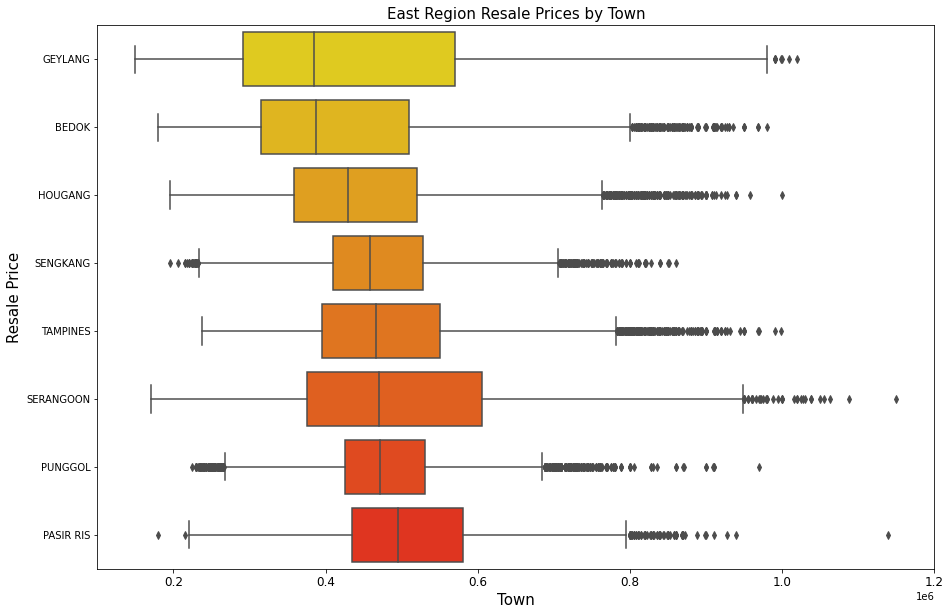

In [40]:
plt.figure(figsize = (15,10))
sb.boxplot(x = 'resale_price', y = 'town', data = east_df,
          order = east_df.groupby('town').median()['resale_price'].sort_values().index,
          palette = 'autumn_r')
plt.title('East Region Resale Prices by Town', fontsize = 15)
plt.xlabel('Town', fontsize = 15)
plt.ylabel('Resale Price', fontsize = 15)
plt.xticks(fontsize = 12);

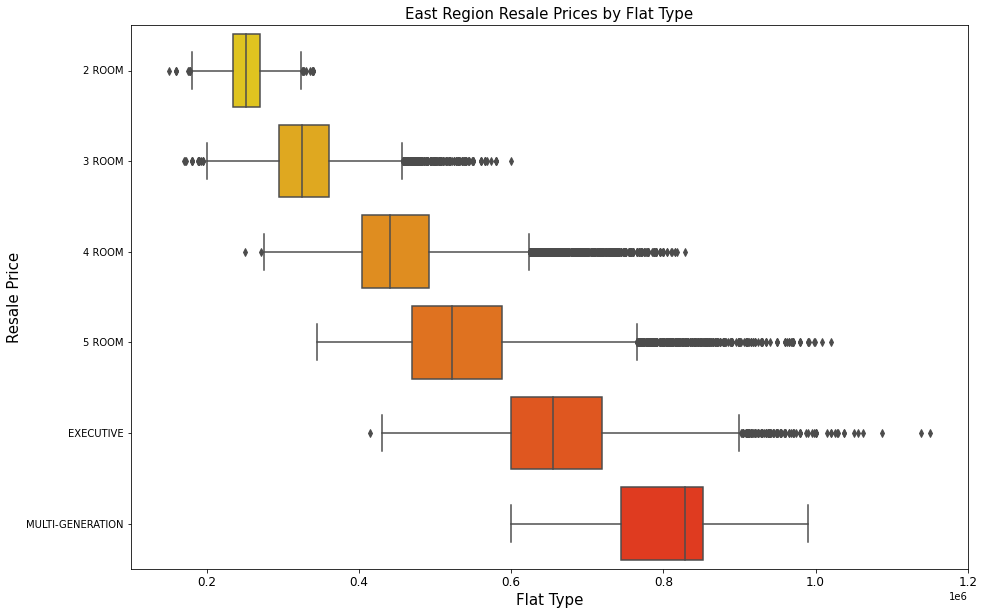

In [41]:
plt.figure(figsize = (15,10))
sb.boxplot(x = 'resale_price', y = 'flat_type', data = east_df,
          palette = 'autumn_r')

plt.title('East Region Resale Prices by Flat Type', fontsize = 15)
plt.xlabel('Flat Type', fontsize = 15)
plt.ylabel('Resale Price', fontsize = 15)
plt.xticks(fontsize = 12);

In [42]:
east_df.corr()

,floor_area_sqm,remaining_lease,resale_price
floor_area_sqm,1.000000,0.127060,0.768586
remaining_lease,0.127060,1.000000,0.142048
resale_price,0.768586,0.142048,1.000000


<AxesSubplot:>

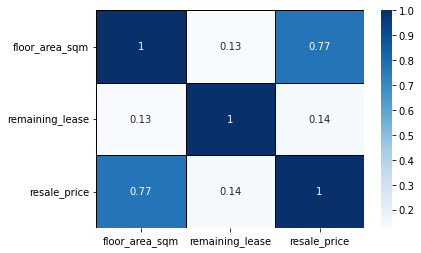

In [43]:
# plt.figure(figsize = (5,4))
sb.heatmap(east_df.corr(),
          cmap = 'Blues',
          annot = True,
          linewidth = 1,
          linecolor = 'black')

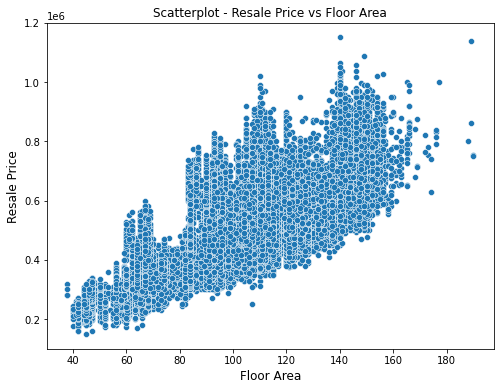

In [44]:
plt.figure(figsize = (8,6))
sb.scatterplot(x = 'floor_area_sqm', y = 'resale_price', data = east_df)

plt.title('Scatterplot - Resale Price vs Floor Area')
plt.xlabel('Floor Area', fontsize = 12)
plt.ylabel('Resale Price', fontsize = 12);

### Linear Regression for Floor Area and Resale Price

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [46]:
east_df.head(2)

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price
119,BEDOK,2 ROOM,01 TO 05,45.0,Improved,73,249000.0
120,BEDOK,2 ROOM,01 TO 05,45.0,Improved,73,268000.0


In [47]:
x = east_df.loc[:, ['floor_area_sqm']].values

In [48]:
x.shape

(85823, 1)

In [49]:
y = east_df.loc[:, ['resale_price']]

In [50]:
y.shape

(85823, 1)

In [51]:
reg = LinearRegression(fit_intercept = True)

In [52]:
reg.fit(x, y)

LinearRegression()

In [53]:
east_pred_df = east_df[['floor_area_sqm', 'resale_price']]

In [54]:
east_pred_df['pred_price'] = reg.predict(east_pred_df['floor_area_sqm'].values.reshape(-1,1))

C:\Users\leowj\AppData\Local\Temp\ipykernel_26260\3990316996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  east_pred_df['pred_price'] = reg.predict(east_pred_df['floor_area_sqm'].values.reshape(-1,1))


In [55]:
reg.score(x,y)

0.5907244387358711

In [56]:
reg.coef_[0]

array([4105.99209512])

In [57]:
reg.intercept_

array([60372.22698284])

In [58]:
print("formula : y = {:.2f}x + {:.2f}".format(reg.coef_[0][0],reg.intercept_[0]))

formula : y = 4105.99x + 60372.23


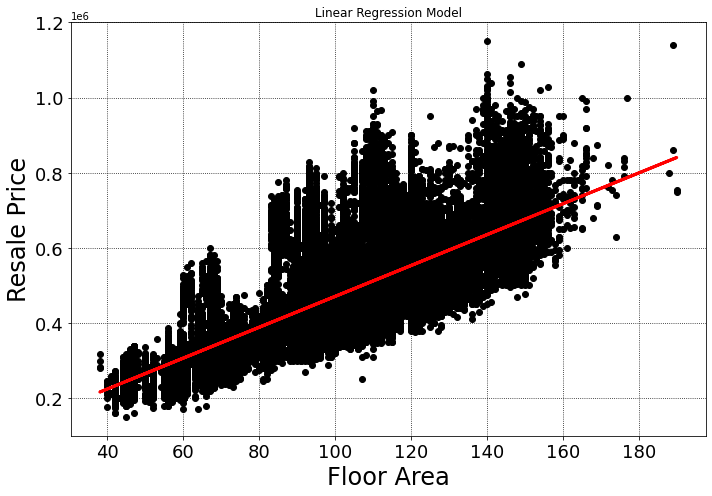

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7));

ax.scatter(x, y, c = 'black');
ax.plot(x, reg.predict(x), c = 'red', linewidth = 3)
ax.grid(True,
       axis = 'both',
       zorder = 0,
       linestyle = ':',
       c = 'k')

ax.tick_params(labelsize = 18)
ax.set_xlabel('Floor Area', fontsize = 24)
ax.set_ylabel('Resale Price', fontsize = 24)
ax.set_title('Linear Regression Model')
fig.tight_layout()

In [63]:
east_df[['floor_area_sqm', 'resale_price']].corr()

,floor_area_sqm,resale_price
floor_area_sqm,1.000000,0.768586
resale_price,0.768586,1.000000
